# Randomized Incremental Construction

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import Delaunay

In [ ]:
def generate_random_points(n_points=50, x_range=(0, 1), y_range=(0, 1), seed=None):
    """
    Generate uniformly distributed random points in 2D space.
    
    Args:
        n_points (int): Number of points to generate. Default is 50.
        x_range (tuple): Range for x-coordinates as (min, max). Default is (0, 1).
        y_range (tuple): Range for y-coordinates as (min, max). Default is (0, 1).
        seed (int, optional): Random seed for reproducibility. Default is None.
    
    Returns:
        np.ndarray: Array of shape (n_points, 2) containing the generated points.
    
    Example:
        >>> points = generate_random_points(n_points=100, seed=42)
        >>> points.shape
        (100, 2)
    """
    if seed is not None:
        np.random.seed(seed)

    x = np.random.uniform(x_range[0], x_range[1], n_points)
    y = np.random.uniform(y_range[0], y_range[1], n_points)
    
    points = np.column_stack((x, y))
    return points

def generate_gaussian_points(n_points=50, mean=(0.5, 0.5), cov=None, seed=None):
    """
    Generate 2D Gaussian distributed points.
    
    Creates points following a multivariate normal distribution. Useful for testing
    algorithms with clustered data patterns.
    
    Args:
        n_points (int): Number of points to generate. Default is 50.
        mean (tuple): Mean position (center) of the distribution. Default is (0.5, 0.5).
        cov (list or np.ndarray, optional): Covariance matrix (2x2). Default is isotropic 
            covariance [[0.02, 0.0], [0.0, 0.02]].
        seed (int, optional): Random seed for reproducibility. Default is None.
    
    Returns:
        np.ndarray: Array of shape (n_points, 2) containing points clipped to [0,1] range.
    
    Example:
        >>> points = generate_gaussian_points(n_points=100, mean=(0.3, 0.7), seed=42)
    """
    if seed is not None:
        np.random.seed(seed)
    if cov is None:
        cov = [[0.02, 0.0], [0.0, 0.02]]  # isotropic default covariance
    points = np.random.multivariate_normal(mean, cov, n_points)
    return np.clip(points, 0, 1)  # keep in [0,1] range


def generate_poisson_disc_points(radius=0.2, x_range=(0, 1), y_range=(0, 1), k=30, seed=None):
    """
    Generate points using Poisson disk sampling (Blue noise distribution).
    
    Creates a set of points where no two points are closer than the specified radius,
    resulting in a more uniform distribution than pure random sampling. This is useful
    for testing algorithms with well-spaced points.
    
    Args:
        radius (float): Minimum distance between any two points. Default is 0.2.
        x_range (tuple): Range for x-coordinates as (min, max). Default is (0, 1).
        y_range (tuple): Range for y-coordinates as (min, max). Default is (0, 1).
        k (int): Number of candidates to try per active point. Default is 30.
        seed (int, optional): Random seed for reproducibility. Default is None.
    
    Returns:
        np.ndarray: Array of shape (m, 2) where m varies based on radius and domain size.
    
    Algorithm:
        Uses Bridson's algorithm for fast Poisson disk sampling:
        1. Creates a grid for spatial lookup
        2. Starts with a random point
        3. Iteratively generates candidates around active points
        4. Accepts candidates that maintain minimum distance
    
    Example:
        >>> points = generate_poisson_disc_points(radius=0.05, seed=42)
    """
    if seed is not None:
        np.random.seed(seed)

    width, height = x_range[1] - x_range[0], y_range[1] - y_range[0]
    cell_size = radius / np.sqrt(2)
    grid_w, grid_h = int(np.ceil(width / cell_size)), int(np.ceil(height / cell_size))
    grid = -np.ones((grid_h, grid_w), dtype=int)
    points = []
    active_list = []

    def in_bounds(p):
        """Check if point is within the specified range."""
        return x_range[0] <= p[0] <= x_range[1] and y_range[0] <= p[1] <= y_range[1]

    def grid_coords(p):
        """Convert point coordinates to grid cell indices."""
        return int((p[0] - x_range[0]) / cell_size), int((p[1] - y_range[0]) / cell_size)

    def too_close(p):
        """Check if point is too close to any existing point."""
        gx, gy = grid_coords(p)
        for i in range(max(gy - 2, 0), min(gy + 3, grid_h)):
            for j in range(max(gx - 2, 0), min(gx + 3, grid_w)):
                idx = grid[i, j]
                if idx != -1:
                    dist = np.linalg.norm(points[idx] - p)
                    if dist < radius:
                        return True
        return False

    # Initial point
    first_point = np.array([
        np.random.uniform(x_range[0], x_range[1]),
        np.random.uniform(y_range[0], y_range[1])
    ])
    points.append(first_point)
    active_list.append(0)
    gx, gy = grid_coords(first_point)
    grid[gy, gx] = 0

    while active_list:
        idx = np.random.choice(active_list)
        base_point = points[idx]
        found = False
        for _ in range(k):
            theta = np.random.uniform(0, 2 * np.pi)
            r = np.random.uniform(radius, 2 * radius)
            new_point = base_point + np.array([r * np.cos(theta), r * np.sin(theta)])
            if in_bounds(new_point) and not too_close(new_point):
                points.append(new_point)
                gx, gy = grid_coords(new_point)
                grid[gy, gx] = len(points) - 1
                active_list.append(len(points) - 1)
                found = True
                break
        if not found:
            active_list.remove(idx)
    return np.array(points)


def generate_clustered_points(n_points=100, n_clusters=3, x_range=(0, 1), y_range=(0, 1), seed=None):
    """
    Generate multiple dense clusters with sparse regions between them.
    
    Creates a dataset with natural clustering patterns by generating multiple 
    Gaussian distributions at random locations. Useful for testing algorithm 
    performance on non-uniform data distributions.
    
    Args:
        n_points (int): Total number of points to generate. Default is 100.
        n_clusters (int): Number of distinct clusters. Default is 3.
        x_range (tuple): Range for x-coordinates as (min, max). Default is (0, 1).
        y_range (tuple): Range for y-coordinates as (min, max). Default is (0, 1).
        seed (int, optional): Random seed for reproducibility. Default is None.
    
    Returns:
        np.ndarray: Array of shape (n_points, 2) clipped to the specified range.
    
    Note:
        Points are distributed roughly equally among clusters, with any remainder
        distributed to the first clusters. Each cluster has a random covariance.
    
    Example:
        >>> points = generate_clustered_points(n_points=200, n_clusters=5, seed=42)
    """
    if seed is not None:
        np.random.seed(seed)
    cluster_centers = np.random.uniform([x_range[0], y_range[0]], [x_range[1], y_range[1]], (n_clusters, 2))
    points_per_cluster = n_points // n_clusters
    remainder = n_points % n_clusters
    points = []
    for i, center in enumerate(cluster_centers):
        size = points_per_cluster + (1 if i < remainder else 0)
        cov = np.diag(np.random.uniform(0.001, 0.01, 2))
        cluster = np.random.multivariate_normal(center, cov, size)
        points.append(cluster)
    return np.clip(np.vstack(points), 0, 1)

##### Implementation Code

In [ ]:

import random
import sys
from collections import defaultdict, deque
import math

# ================================================
#  PREDICATES (Geometry Math)
# ================================================

EPS = 1e-10

def orient_ric(points, i, j, k):
    """
    Compute the orientation of three points (counter-clockwise test).
    
    Calculates twice the signed area of the triangle formed by points i, j, k.
    
    Args:
        points (list): List of points where each point is (x, y).
        i, j, k (int): Indices of the three points to test.
    
    Returns:
        float: Positive if counter-clockwise, negative if clockwise, 0 if collinear.
    
    Mathematical Formula:
        det = (b.x - a.x)(c.y - a.y) - (b.y - a.y)(c.x - a.x)
    """
    a, b, c = points[i], points[j], points[k]
    return (b[0]-a[0])*(c[1]-a[1]) - (b[1]-a[1])*(c[0]-a[0])

def in_circle_RIC(points, i, j, k, l):
    """
    Test if point l is inside the circumcircle of triangle (i, j, k).
    
    Uses the determinant-based in-circle test for robust geometric computation.
    This is a fundamental predicate for the Delaunay triangulation property.
    
    Args:
        points (list): List of points where each point is (x, y).
        i, j, k (int): Indices of triangle vertices (must be CCW ordered).
        l (int): Index of the point to test.
    
    Returns:
        bool: True if point l is strictly inside the circumcircle, False otherwise.
    
    Mathematical Formula:
        Computes the determinant:
        | ax²+ay²  ax  ay  1 |
        | bx²+by²  bx  by  1 |
        | cx²+cy²  cx  cy  1 |
        | dx²+dy²  dx  dy  1 |
        where all coordinates are relative to point d (l).
    """
    a, b, c, d = points[i], points[j], points[k], points[l]
    ax, ay = a[0]-d[0], a[1]-d[1]
    bx, by = b[0]-d[0], b[1]-d[1]
    cx, cy = c[0]-d[0], c[1]-d[1]

    det = (ax*ax+ay*ay)*(bx*cy - cx*by) \
        - (bx*bx+by*by)*(ax*cy - cx*ay) \
        + (cx*cx+cy*cy)*(ax*by - bx*ay)
        
    return det > EPS

# ================================================
#  OPTIMIZED HISTORY DAG
# ================================================

class HistoryDAG:
    """
    History Directed Acyclic Graph for efficient point location.
    
    The History DAG tracks the evolution of the triangulation as points are added.
    Each triangle that existed at some point becomes a node. When a triangle is
    split or flipped, edges point from the old triangle(s) to the new one(s).
    
    This structure enables O(log n) expected point location by walking from the
    root (super-triangle) down to the current triangulation.
    
    Attributes:
        children (dict): Maps triangle ID to list of child triangle IDs.
        root (int): Triangle ID of the initial super-triangle.
    
    Time Complexity:
        Point location: O(log n) expected, O(n) worst case
    """
    
    def __init__(self):
        """Initialize an empty history DAG."""
        self.children = {}  # Key: tid, Value: list of child_tids
        self.root = None

    def set_root(self, tid):
        """
        Set the root triangle of the DAG (typically the super-triangle).
        
        Args:
            tid (int): Triangle ID to set as root.
        """
        self.root = tid

    def add_split(self, parent_tid, child_tids):
        """
        Record a triangle split operation.
        
        Called when a point is inserted inside a triangle, splitting it into
        three new triangles.
        
        Args:
            parent_tid (int): ID of the triangle being split.
            child_tids (list): IDs of the three new triangles created.
        """
        self.children[parent_tid] = list(child_tids)

    def add_flip(self, parent1, parent2, child1, child2):
        """
        Record an edge flip operation.
        
        Called when an edge is flipped between two adjacent triangles,
        replacing them with two new triangles.
        
        Args:
            parent1, parent2 (int): IDs of the two triangles being removed.
            child1, child2 (int): IDs of the two new triangles created.
        """
        self.children[parent1] = [child1, child2]
        self.children[parent2] = [child1, child2]

    def find_containing_triangle(self, points, triangles, alive, p_idx):
        """
        Locate which active triangle contains the given point.
        
        Walks down the DAG from root to a leaf (active triangle), using
        orientation tests to determine which child to follow at each step.
        
        Args:
            points (list): All points in the triangulation.
            triangles (dict): Map from triangle ID to (i, j, k) vertex tuple.
            alive (set): Set of triangle IDs that are currently active.
            p_idx (int): Index of point to locate.
        
        Returns:
            int: Triangle ID of the active triangle containing point p_idx,
                 or None if location fails (robustness fallback).
        
        Algorithm:
            1. Start at root
            2. While current triangle is not alive:
               - Test point against each child triangle
               - Move to the child that contains the point
            3. Return current triangle when it's alive
            4. If path fails, do linear search (robustness)
        """
        curr = self.root
        
        # Descend the DAG until we hit a live triangle
        while curr not in alive:
            found_next = False
            children = self.children.get(curr, [])
            
            for child_id in children:
                # Get indices of the child triangle
                i, j, k = triangles[child_id]
                
                # Check if point is inside this child (barycentric test)
                if (orient_ric(points, i, j, p_idx) >= -EPS and 
                    orient_ric(points, j, k, p_idx) >= -EPS and 
                    orient_ric(points, k, i, p_idx) >= -EPS):
                    
                    curr = child_id
                    found_next = True
                    break
            
            if not found_next:
                # Robustness Fallback: Linear search if precision errors occur
                for t in alive:
                    i, j, k = triangles[t]
                    if (orient_ric(points, i, j, p_idx) >= -EPS and 
                        orient_ric(points, j, k, p_idx) >= -EPS and 
                        orient_ric(points, k, i, p_idx) >= -EPS):
                        return t
                return None

        return curr

# ================================================
#  TRIANGLE & EDGE HELPERS
# ================================================

def edge_key_RIC(u, v):
    """
    Create a canonical edge key for consistent edge lookup.
    
    Args:
        u, v (int): Vertex indices.
    
    Returns:
        tuple: (min(u,v), max(u,v)) ensuring consistent ordering.
    """
    return (u, v) if u < v else (v, u)

_tid_counter = 0
def new_tid():
    """
    Generate a unique triangle ID.
    
    Returns:
        int: Next available triangle ID.
    """
    global _tid_counter
    t = _tid_counter
    _tid_counter += 1
    return t

def add_triangle_RIC(points, triangles, alive, edge_map, i, j, k):
    """
    Create and register a new triangle in the triangulation.
    
    Ensures the triangle is in counter-clockwise orientation and updates
    all necessary data structures.
    
    Args:
        points (list): All points in the triangulation.
        triangles (dict): Map from triangle ID to vertex tuple.
        alive (set): Set of currently active triangle IDs.
        edge_map (defaultdict): Map from edge to set of adjacent triangles.
        i, j, k (int): Vertex indices of the new triangle.
    
    Returns:
        int: ID of the newly created triangle.
    
    Side Effects:
        - Adds triangle to triangles dict
        - Adds triangle ID to alive set
        - Updates edge_map for all three edges
    """
    # Ensure Counter-Clockwise Order
    if orient_ric(points, i, j, k) < 0:
        i, j = j, i 
        
    tid = new_tid()
    triangles[tid] = (i, j, k)
    alive.add(tid)
    
    # Map edges to this triangle
    for u, v in [(i, j), (j, k), (k, i)]:
        edge_map[edge_key_RIC(u, v)].add(tid)
        
    return tid

def kill_triangle_RIC(alive, edge_map, triangles, tid):
    """
    Remove a triangle from the active triangulation.
    
    Args:
        alive (set): Set of active triangle IDs.
        edge_map (defaultdict): Map from edge to set of adjacent triangles.
        triangles (dict): Map from triangle ID to vertex tuple.
        tid (int): Triangle ID to remove.
    
    Side Effects:
        - Removes triangle from alive set
        - Removes triangle from edge_map entries
        - Cleans up empty edge_map entries
    """
    if tid in alive:
        alive.remove(tid)
        tri = triangles[tid]
        for u, v in [(tri[0], tri[1]), (tri[1], tri[2]), (tri[2], tri[0])]:
            key = edge_key_RIC(u, v)
            if key in edge_map:
                edge_map[key].discard(tid)
                if not edge_map[key]:
                    del edge_map[key]

# ================================================
#  FLIP & LEGALIZE
# ================================================

def flip_edge_RIC(points, triangles, alive, edge_map, dag, t1, t2, u, v):
    """
    Flip the shared edge between two adjacent triangles.
    
    Replaces edge (u,v) with edge (opp1, opp2) where opp1 and opp2 are
    the vertices opposite to the edge in each triangle.
    
    Args:
        points (list): All points in the triangulation.
        triangles (dict): Map from triangle ID to vertex tuple.
        alive (set): Set of active triangle IDs.
        edge_map (defaultdict): Map from edge to set of adjacent triangles.
        dag (HistoryDAG): History DAG for point location.
        t1, t2 (int): IDs of the two triangles sharing the edge.
        u, v (int): Vertices of the shared edge.
    
    Returns:
        tuple: (n1, n2) IDs of the two new triangles created.
    
    Algorithm:
        Before:  u----v        After:  u    v
                / \  / \              / |  | \
               /t1 \/t2 \            /  |  |  \
              /    /\    \          / t1| n|t2 \
            opp1  /  \  opp2     opp1  /  \  opp2
        
        Edge (u,v) becomes edge (opp1, opp2)
    """
    tri1 = triangles[t1]
    tri2 = triangles[t2]
    
    # Identify opposite vertices
    opp1 = [x for x in tri1 if x != u and x != v][0]
    opp2 = [x for x in tri2 if x != u and x != v][0]

    # New triangles: (u, opp1, opp2) and (v, opp2, opp1)
    n1 = add_triangle_RIC(points, triangles, alive, edge_map, u, opp1, opp2)
    n2 = add_triangle_RIC(points, triangles, alive, edge_map, v, opp2, opp1)

    # Update DAG
    dag.add_flip(t1, t2, n1, n2)
    
    # Kill old
    kill_triangle_RIC(alive, edge_map, triangles, t1)
    kill_triangle_RIC(alive, edge_map, triangles, t2)

    return n1, n2

def legalize_RIC(points, triangles, alive, edge_map, dag, tid):
    """
    Recursively ensure the Delaunay property for triangle and its neighbors.
    
    Checks each edge of the triangle. If an adjacent triangle violates the
    Delaunay condition (opposite vertex inside circumcircle), flips the edge
    and recursively legalizes the new triangles.
    
    Args:
        points (list): All points in the triangulation.
        triangles (dict): Map from triangle ID to vertex tuple.
        alive (set): Set of active triangle IDs.
        edge_map (defaultdict): Map from edge to set of adjacent triangles.
        dag (HistoryDAG): History DAG for point location.
        tid (int): Triangle ID to legalize.
    
    Algorithm (Edge Flip Test):
        For each edge (u,v) of triangle tid with opposite vertex w:
        1. Find neighboring triangle across edge (u,v) with opposite vertex z
        2. Test if z is inside circumcircle of (u,v,w)
        3. If yes, flip edge and recursively legalize new triangles
    
    Time Complexity: O(degree of vertex) per insertion, O(1) expected amortized
    """
    if tid not in alive: return

    tri = triangles[tid]
    # Check edges (copy list because structure changes during loop)
    edges = [(tri[0], tri[1]), (tri[1], tri[2]), (tri[2], tri[0])]

    for u, v in edges:
        key = edge_key_RIC(u, v)
        neighbors = edge_map.get(key, set())
        
        neighbor_tid = None
        for n in neighbors:
            if n != tid:
                neighbor_tid = n
                break
        
        if neighbor_tid is None: continue 

        # Find opposite vertex in neighbor
        ntri = triangles[neighbor_tid]
        opp_node = [x for x in ntri if x != u and x != v][0]

        # Find opposite vertex in current
        current_opp = [x for x in tri if x != u and x != v][0]

        # Delaunay Check: Is opp_node inside circumcircle of current triangle?
        if in_circle_RIC(points, u, v, current_opp, opp_node):
            new_t1, new_t2 = flip_edge_RIC(points, triangles, alive, edge_map, dag, tid, neighbor_tid, u, v)
            legalize_RIC(points, triangles, alive, edge_map, dag, new_t1)
            legalize_RIC(points, triangles, alive, edge_map, dag, new_t2)
            return

# ================================================
#  MAIN DRIVER
# ================================================

def triangulate_ric(points_input):
    """
    Compute Delaunay triangulation using Randomized Incremental Construction.
    
    This algorithm builds a Delaunay triangulation by inserting points in random
    order and maintaining the Delaunay property through edge flips. It uses a
    history DAG for efficient point location.
    
    Time Complexity: O(n log n) expected, O(n²) worst case
    Space Complexity: O(n)
    
    Args:
        points_input (array-like): Input points as list/array of (x,y) coordinates.
    
    Returns:
        list: List of tuples (i, j, k) representing triangle vertex indices.
    
    Algorithm Overview:
        1. Create super-triangle encompassing all points
        2. Randomize point insertion order
        3. For each point:
           a. Locate containing triangle using history DAG
           b. Split triangle into three new triangles
           c. Recursively legalize edges to maintain Delaunay property
        4. Remove triangles connected to super-triangle vertices
    
    Key Features:
        - History DAG for O(log n) expected point location
        - Edge flipping to maintain Delaunay condition
        - Robust geometric predicates
        - Randomization for expected performance guarantees
    
    Example:
        >>> points = [(0, 0), (1, 0), (0.5, 1)]
        >>> tris = triangulate_ric(points)
        >>> len(tris)
        1
    
    References:
        Guibas, L., & Stolfi, J. (1985). Primitives for the manipulation of 
        general subdivisions and the computation of Voronoi diagrams.
    """
    global _tid_counter
    _tid_counter = 0

    # Ensure inputs are standard list of tuples
    pts = [tuple(p) for p in points_input]
    n = len(pts)
    
    # Create Supertriangle
    xs = [p[0] for p in pts]
    ys = [p[1] for p in pts]
    dx, dy = max(xs)-min(xs), max(ys)-min(ys)
    delta = max(dx, dy) * 10
    mid_x, mid_y = (min(xs)+max(xs))/2, (min(ys)+max(ys))/2
    
    p1 = (mid_x - 20 * delta, mid_y - delta)
    p2 = (mid_x, mid_y + 20 * delta)
    p3 = (mid_x + 20 * delta, mid_y - delta)
    
    pts.extend([p1, p2, p3])
    
    # Init Structures
    triangles = {}     
    alive = set()      
    edge_map = defaultdict(set)
    dag = HistoryDAG() 
    
    root_id = add_triangle_RIC(pts, triangles, alive, edge_map, n, n+1, n+2)
    dag.set_root(root_id)

    # Insert Points in Random Order
    indices = list(range(n))
    random.shuffle(indices)

    for i in indices:
        # Point Location
        tid = dag.find_containing_triangle(pts, triangles, alive, i)
        
        if tid is None: continue

        # Split Triangle
        a, b, c = triangles[tid]
        kill_triangle_RIC(alive, edge_map, triangles, tid)
        
        t1 = add_triangle_RIC(pts, triangles, alive, edge_map, a, b, i)
        t2 = add_triangle_RIC(pts, triangles, alive, edge_map, b, c, i)
        t3 = add_triangle_RIC(pts, triangles, alive, edge_map, c, a, i)
        
        dag.add_split(tid, [t1, t2, t3])
        
        # Legalize Edges
        legalize_RIC(pts, triangles, alive, edge_map, dag, t1)
        legalize_RIC(pts, triangles, alive, edge_map, dag, t2)
        legalize_RIC(pts, triangles, alive, edge_map, dag, t3)

    # Extract Final Triangles (Filter out supertriangle indices >= n)
    final_triangles = []
    for tid in alive:
        a, b, c = triangles[tid]
        if a < n and b < n and c < n:
            final_triangles.append((a, b, c))
            
    return final_triangles



##### Comparison with SciPy Delaunay Triangulation

Verification with 20 points for each dataset:

Random       - RIC:  33 triangles, Scipy:  33 triangles, Match: True
Gaussian     - RIC:  30 triangles, Scipy:  30 triangles, Match: True
Clustered    - RIC:  30 triangles, Scipy:  30 triangles, Match: True
Poisson      - RIC:  34 triangles, Scipy:  34 triangles, Match: True


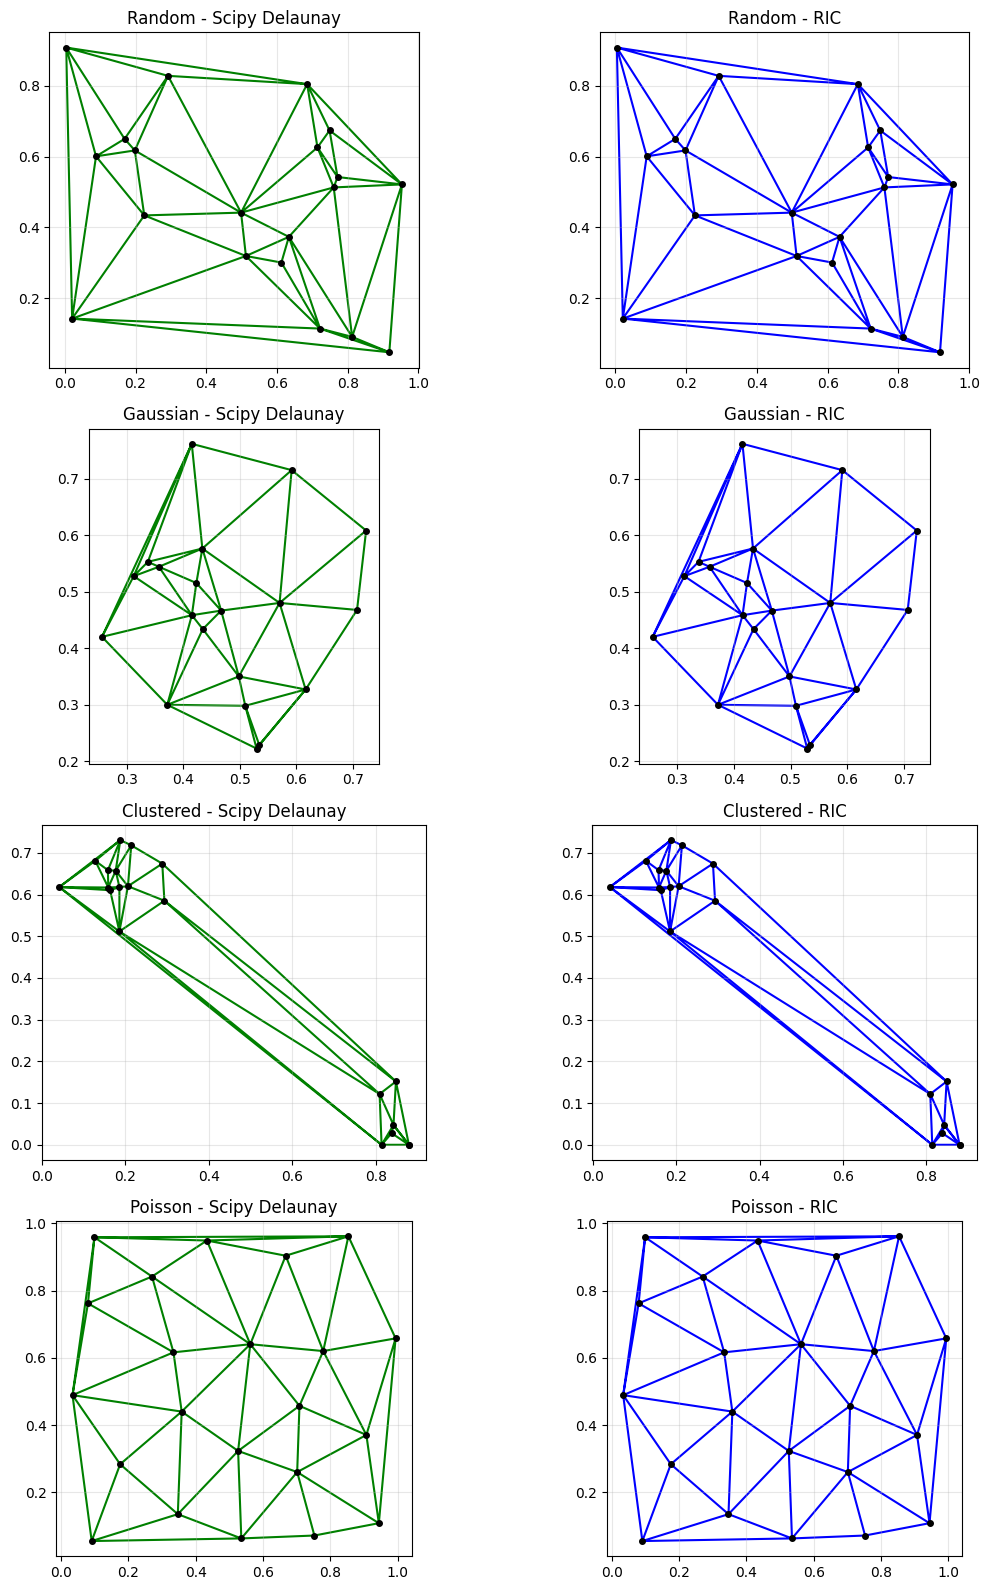

In [13]:
# Verification Step
import matplotlib.pyplot as plt
from scipy.spatial import Delaunay
import numpy as np

# 1. Generate Data
n_verify = 20
points_verify = generate_random_points(n_points=n_verify, seed=10)
np.random.shuffle(points_verify)

points_verify_gauss = generate_gaussian_points(n_points=n_verify, seed=42)
np.random.shuffle(points_verify_gauss)

points_verify_clustered = generate_clustered_points(n_points=n_verify, seed=52)
np.random.shuffle(points_verify_clustered)

r = np.sqrt(0.625 / n_verify) 
points_verify_poisson = generate_poisson_disc_points(radius=r, seed=62)
np.random.shuffle(points_verify_poisson)

# 2. Run Flip Algorithm
custom_triangles = triangulate_ric(points_verify)
custom_triangles_gauss = triangulate_ric(points_verify_gauss)
custom_triangles_clustered = triangulate_ric(points_verify_clustered)
custom_triangles_poisson = triangulate_ric(points_verify_poisson)
# 3. Run Scipy Delaunay
delaunay = Delaunay(points_verify)
delaunay_gauss = Delaunay(points_verify_gauss)
delaunay_clustered = Delaunay(points_verify_clustered)
delaunay_poisson = Delaunay(points_verify_poisson)

scipy_simplices = delaunay.simplices
scipy_simplices_gauss = delaunay_gauss.simplices
scipy_simplices_clustered = delaunay_clustered.simplices
scipy_simplices_poisson = delaunay_poisson.simplices

# 4. Compare Results for all datasets
datasets = [
    ("Random", custom_triangles, scipy_simplices, points_verify),
    ("Gaussian", custom_triangles_gauss, scipy_simplices_gauss, points_verify_gauss),
    ("Clustered", custom_triangles_clustered, scipy_simplices_clustered, points_verify_clustered),
    ("Poisson", custom_triangles_poisson, scipy_simplices_poisson, points_verify_poisson)
]

print(f"Verification with {n_verify} points for each dataset:\n")
for name, custom, scipy, _ in datasets:
    custom_set = set(tuple(sorted(t)) for t in custom)
    scipy_set = set(tuple(sorted(t)) for t in scipy)
    is_correct = (custom_set == scipy_set)
    
    print(f"{name:12} - RIC: {len(custom_set):3d} triangles, Scipy: {len(scipy_set):3d} triangles, Match: {is_correct}")
    
    if not is_correct:
        print(f"  → In RIC only: {custom_set - scipy_set}")
        print(f"  → In Scipy only: {scipy_set - custom_set}")

# 5. Visualize All Datasets in a Grid
fig, axes = plt.subplots(4, 2, figsize=(12, 16))

for idx, (name, custom, scipy, points) in enumerate(datasets):
    # Scipy Plot (left column)
    axes[idx, 0].set_title(f"{name} - Scipy Delaunay")
    if len(scipy) > 0:
        axes[idx, 0].triplot(points[:, 0], points[:, 1], scipy, color='green')
    axes[idx, 0].plot(points[:, 0], points[:, 1], 'ko', markersize=4)
    axes[idx, 0].set_aspect('equal')
    axes[idx, 0].grid(True, alpha=0.3)
    
    # RIC Plot (right column)
    axes[idx, 1].set_title(f"{name} - RIC")
    if custom:
        axes[idx, 1].triplot(points[:, 0], points[:, 1], [list(t) for t in custom], color='blue')
    axes[idx, 1].plot(points[:, 0], points[:, 1], 'ko', markersize=4)
    axes[idx, 1].set_aspect('equal')
    axes[idx, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### Dataset Testing

Running for n=1000...
Running for n=1500...
Running for n=1500...
Running for n=2000...
Running for n=2000...
Running for n=2500...
Running for n=2500...
Running for n=3000...
Running for n=3000...
Running for n=3500...
Running for n=3500...
Running for n=4000...
Running for n=4000...
Running for n=4500...
Running for n=4500...
Running for n=5000...
Running for n=5000...
Running for n=5500...
Running for n=5500...
Running for n=6000...
Running for n=6000...
Running for n=6500...
Running for n=6500...
Running for n=7000...
Running for n=7000...
Running for n=7500...
Running for n=7500...
Running for n=8000...
Running for n=8000...
Running for n=8500...
Running for n=8500...
Running for n=9000...
Running for n=9000...
Running for n=9500...
Running for n=9500...


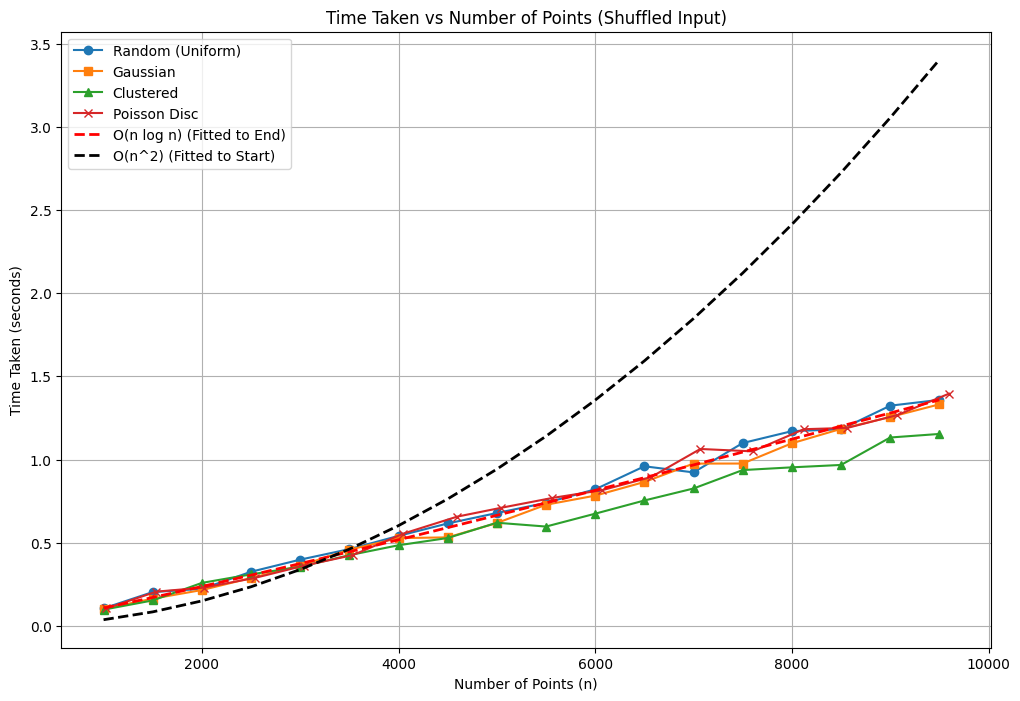

In [12]:
import time
import matplotlib.pyplot as plt
import numpy as np

ns = [i for i in range(1000, 10000, 500)]

results = {
    "Random": [],
    "Gaussian": [],
    "Clustered": [],
    "Poisson": []
}

for n in ns:
    print(f"Running for n={n}...")
    
    # Random
    pts = generate_random_points(n_points=n, seed=10)
    np.random.shuffle(pts)
    start_time = time.time()
    triangulate_ric(pts)
    end_time = time.time()
    results["Random"].append(end_time - start_time)
    
    # Gaussian
    pts = generate_gaussian_points(n_points=n, seed=42)
    np.random.shuffle(pts) # Shuffle to remove input order bias
    start_time = time.time()
    triangulate_ric(pts)
    end_time = time.time()
    results["Gaussian"].append(end_time - start_time)
    
    # Clustered
    pts = generate_clustered_points(n_points=n, seed=52)
    np.random.shuffle(pts) # Shuffle to remove input order bias
    start_time = time.time()
    triangulate_ric(pts)
    end_time = time.time()
    results["Clustered"].append(end_time - start_time)
    
    # Poisson
    r = np.sqrt(0.625 / n) 
    pts = generate_poisson_disc_points(radius=r, seed=62)
    np.random.shuffle(pts) # Shuffle to remove input order bias
    start_time = time.time()
    triangulate_ric(pts)
    end_time = time.time()
    results["Poisson"].append((len(pts), end_time - start_time))

# Plotting
plt.figure(figsize=(12, 8))
plt.plot(ns, results["Random"], label="Random (Uniform)", marker='o')
plt.plot(ns, results["Gaussian"], label="Gaussian", marker='s')
plt.plot(ns, results["Clustered"], label="Clustered", marker='^')

# Poisson scatter/line
p_ns = [x[0] for x in results["Poisson"]]
p_times = [x[1] for x in results["Poisson"]]

# Sort by n (just in case)
p_sorted = sorted(zip(p_ns, p_times))
p_ns = [x[0] for x in p_sorted]
p_times = [x[1] for x in p_sorted]

plt.plot(p_ns, p_times, label="Poisson Disc", marker='x')

# Theoretical Lines
ns_arr = np.array(ns)

# Use the maximum time from Random as a reference for scaling
# We use the last point to anchor the theoretical curves
if results["Random"]:
    # 1. Fit O(n log n) to the LAST point (Max N)
    # This checks: "Does my data follow this shape?"
    ref_n_last = ns[-1]
    ref_time_last = results["Random"][-1]
    
    k_log = ref_time_last / (ref_n_last * np.log(ref_n_last))
    plt.plot(ns, k_log * (ns_arr * np.log(ns_arr)), 'r--', label="O(n log n) (Fitted to End)", linewidth=2)

    # 2. Fit O(n^2) to an EARLY point (e.g., the 5th point)
    # This checks: "If this were quadratic, where would it be by now?"
    # We skip index 0-4 to avoid initial startup noise/caching jitter
    ref_idx = 5 
    if len(ns) > ref_idx:
        ref_n_early = ns[ref_idx]
        ref_time_early = results["Random"][ref_idx]
        k2 = ref_time_early / (ref_n_early**2)
        plt.plot(ns, k2 * (ns_arr**2), 'k--', label="O(n^2) (Fitted to Start)", linewidth=2)

plt.xlabel("Number of Points (n)")
plt.ylabel("Time Taken (seconds)")
plt.title("Time Taken vs Number of Points (Shuffled Input)")
plt.legend()
plt.grid(True)
plt.show()